In [1]:
%load_ext tikzmagic
%matplotlib inline

In [2]:
import os
import subprocess
import sys
from collections import namedtuple

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from colormaps import viridis  # DEATH TO JET!

# Pylearn 2 Imports
from pylearn2.config import yaml_parse
from pylearn2.utils import serial

# Add my Python utils to the path
sys.path.append(os.path.join('..', 'Sean', 'py_utils'))

# Some imports from local files
from compare_output import compare_guesses, compare_output
from pgm import read_pgm, write_pgm
from raw import read_raw

### Preface: Don't use jet

In this notebook, none of the output data ends up on something like a heatmap that uses a color scale to represent 2 dimensional data, however, some of the input height data is plotted this way.  I have explicitly chosen not to use jet, the default color map currently in matplotlib (until version 2.0 is released) because **jet is terrible**.

To show this we will plot the function
$$z = \cos\left(x^2\right) e^{-y}$$
to give you an idea of what that looks like, here is that function in greyscale:

In [3]:
x = np.linspace(0, 6)
y = np.linspace(0, 3)[:, np.newaxis]
z = 10 * np.cos(x ** 2) * np.exp(-y)

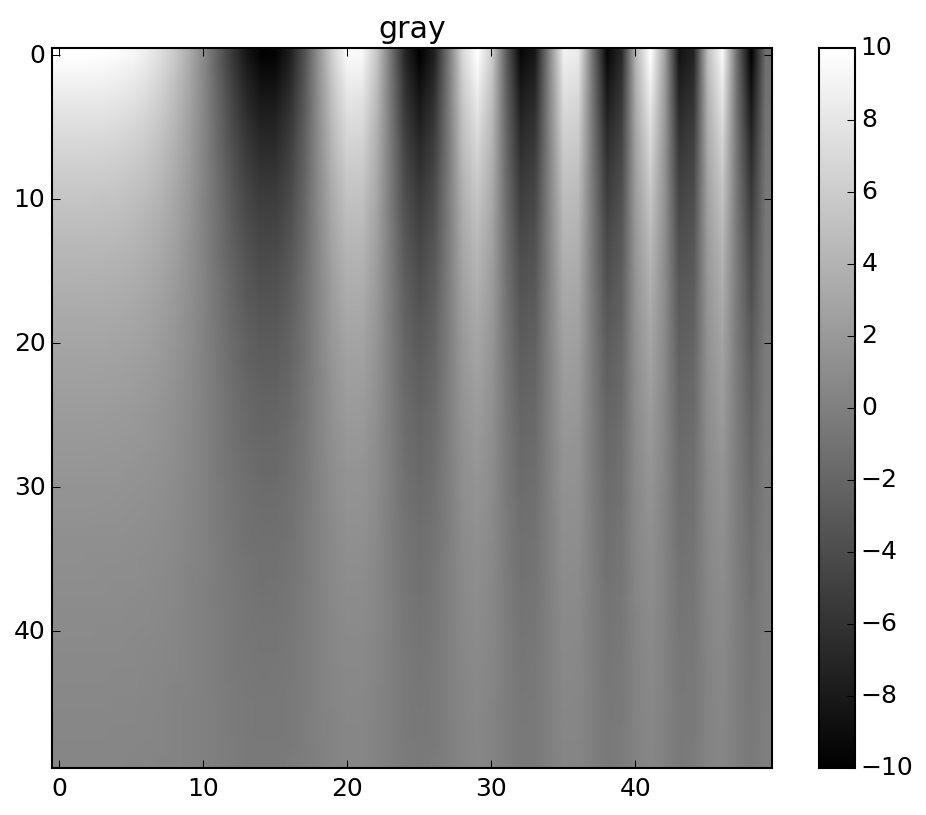

In [10]:
plt.imshow(z, cmap=plt.cm.gray)
plt.colorbar()
plt.title("gray")

now here it is again in jet, and also in a greyscale version of jet:

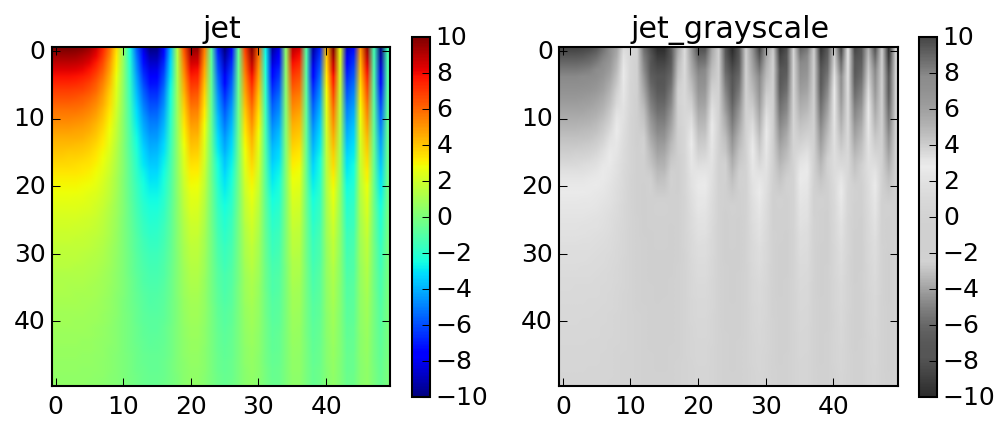

In [15]:
def grayify_cmap(cmap):
    """Return a grayscale version of the colormap"""
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived greyscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
    
    return mpl.colors.LinearSegmentedColormap.from_list(cmap.name + "_grayscale", colors, cmap.N)

cmaps = [plt.cm.jet, grayify_cmap(plt.cm.jet)]
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
fig.subplots_adjust(wspace=0.2)

for cmap, ax in zip(cmaps, axes):
    im = ax.imshow(z, cmap=cmap)
    ax.set_title(cmap.name)
    fig.colorbar(im, ax=ax)

AH!

Now here is the same thing with viridis, what will become the new default colorscheme in matplotlib 2.0, and which I have included (along with 3 other nice colormaps, magma, plasma, and inferno) in `colormaps.py`.

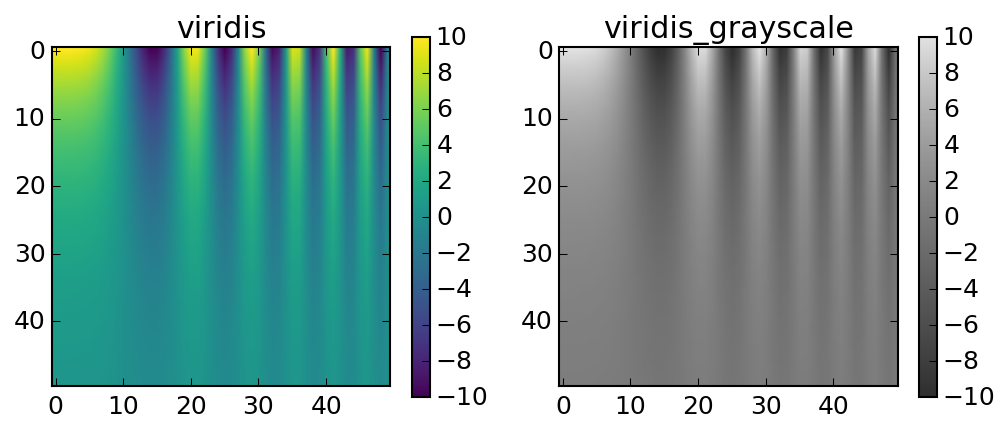

In [16]:
cmaps = [viridis, grayify_cmap(viridis)]
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
fig.subplots_adjust(wspace=0.2)

for cmap, ax in zip(cmaps, axes):
    im = ax.imshow(z, cmap=cmap)
    ax.set_title(cmap.name)
    fig.colorbar(im, ax=ax)

Much better!

To summarize, here is a [data visualization haiku](https://twitter.com/michaelwaskom/status/512344441873367040)
```
you have some data
that needs to be colorful,
don't fucking use jet.
```

More information can be found [here](https://www.youtube.com/watch?v=xAoljeRJ3lU) and [here](https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/).

# Neural Network Image Processing with Pylearn2 for the JPL Space Design Competition

## or: How I Learned to Stop Worrying and Love the Net

---

![](jpl.svg)

https://wiki.cites.illinois.edu/wiki/display/jplteam

April, 2015, the aerospace department hosted a competition put on in conjunction with the NASA Jet Propulsion Laboratory which asked students to build an algorithm to identify safe landing zones on a series of hypothetical planetary surfaces given a limited set of overhead images and terrain data.  While this sort of task is very important for NASA, nearly identical classification tasks can easily by construction for other industrial applications, such as landing drones (think Amazon drone delivery).

Because this is a classification problem with a large component being image processing, we figured machine learning would be very well suited.  We have in this problem a clear set of geometric constraints, and at the outset, we were unsure if we could construct an algorithm that would be able to handle all of the different constraints.

In [3]:
# Define the locations of input things
train_dir = os.path.join("..", "training data", "terrainS{slope}C{crater}R{roughness}_100")
pgm_file = os.path.join(train_dir, "terrainS{slope}C{crater}R{roughness}_100.pgm")
raw_file = os.path.join(train_dir, "terrainS{slope}C{crater}R{roughness}_100_500by500_dem.raw")
soln_file = os.path.join(train_dir, "terrainS{slope}C{crater}R{roughness}_100.invHazard.pgm")

# Define the locations of output things
output_dir = os.path.join("..", "Sean", "nn_files_S{slope}C{crater}R{roughness}")
output_pgm = os.path.join(output_dir, "out_preprocessing_S{slope}C{crater}R{roughness}.pgm")
output_png = os.path.join(output_dir, "out_preprocessing_S{slope}C{crater}R{roughness}.png")
output_nn_safe = os.path.join(output_dir, "nn_outS{slope}C{crater}R{roughness}_safe.raw")
output_nn_safe = os.path.join(output_dir, "nn_outS{slope}C{crater}R{roughness}_unsafe.raw")

difficulty = namedtuple("Difficulty", ["slope", "crater", "roughness"])
diffs = list(map(lambda x: difficulty(*x), [(0, 0, 10), (4, 0, 10), (4, 4, 10), (4, 4, 20)]))

# Problem

**Can we use neural networks to identify "safe" landing sites on a planetary surface?**

For each potential landing site (100 m x 100 m), we are given two sets of data:

1. The terrain height, with a resolution of 0.2 m (500x500 pixels), as a raw file of 32-bit floats

2. An overhead image of the landing site, with the sun from the east at 30° above the horizon, with a resolution of 0.1 m (1000x1000 pixels), as a pgm image file of 8-bit integers

In this scenario, this data would correspond to a coarse satelite imaging of the surface and a snapshot taken by the rover during the descent, respectively.  Because of the relatively low sampling density, brute forcing the problem from the height data alone is not sufficient, we need some intelligent data processing scheme.

From these two sets of data, we must construct a corresponding 1000x1000 pixel map of acceptable landing locations.

## Geometric Constraints

The rover that we must consider is one with the following dimensions:

![](lander.svg)

For a given location to be considered safe, the rover must be able to land safely in all rotational configurations about its center.

There are two key constraints that disqualify a potential landing zone:

### Slope hazards

If the landing spot of the rover is at too great a slope, the rover runs the risk of toppling over. The maximum allowed tilt from vertical is 10°.

![](slope_hazard.svg)

### Roughness hazards

There must be nothing below the rover that will make contact with the lower base of the rover, so there must be clearance over any rock or similar hazard.

![](roughness_hazard.svg)

----

# Provided Information

$\rightarrow$ 4 Training sets of varying difficulty

Easiest landing site only has roughness hazards (rocks), then slopes, craters, and additional roghness are added in succession for each of the three subsequent data sets.  For each data set, the height and image data, as noted above, are provided, in addition to the correct solution.

The algorithm is judged on its ability to solve not only the provided sets of data, but another batch of 4 data sets on the day of the competition.

## Height Data

In [5]:
vmax = max(np.max(read_raw(raw_file.format(**scr._asdict()), 500, 500)) for scr in diffs)
vmin = min(np.min(read_raw(raw_file.format(**scr._asdict()), 500, 500)) for scr in diffs)

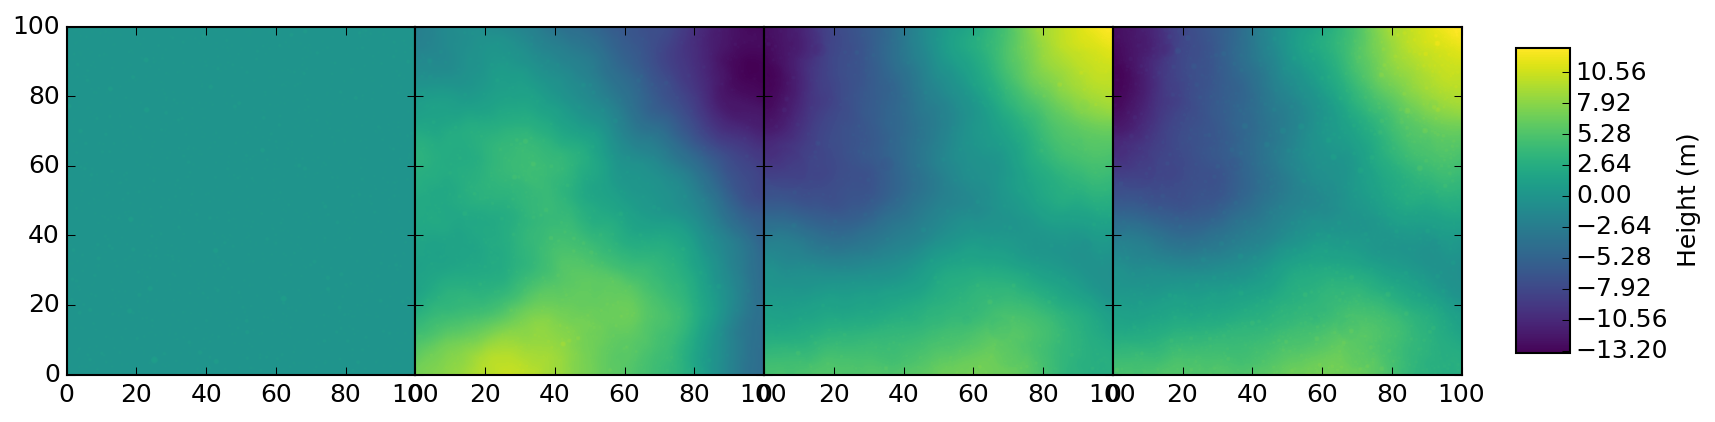

In [9]:
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 2.9)

x = np.linspace(0, 100, 500)
X, Y = np.meshgrid(x, x)

for i, scr in enumerate(diffs):
    # Here's the data we'll plot
    raw = read_raw(raw_file.format(**scr._asdict()), 500, 500)
    
    ax = axs[i]
    cf = ax.contourf(X, Y, raw, 500, cmap=viridis, vmax=vmax, vmin=vmin)
    
    ax.set_aspect('equal')
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)

fig.subplots_adjust(hspace=0, wspace=0, right=0.9)
cb_ax = fig.add_axes([0.93, 0.15, 0.03, 0.7])
cb = fig.colorbar(cf, cax=cb_ax)
cb.set_label('Height (m)')

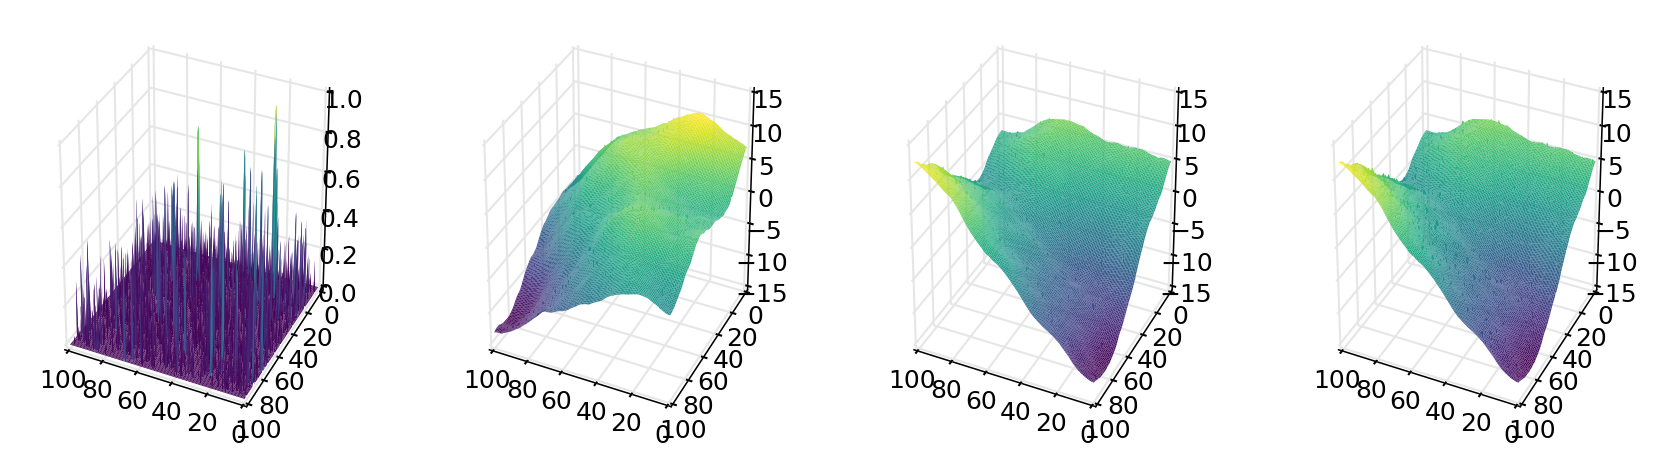

In [6]:
fig = plt.figure()
fig.set_size_inches(14, 3.5)

x = np.linspace(0, 100, 500)
X, Y = np.meshgrid(x, x)

for i, scr in enumerate(diffs, start=1):
    # Here's the data we'll plot
    raw = read_raw(raw_file.format(**scr._asdict()), 500, 500)

    ax = fig.add_subplot(1, 4, i, projection='3d')
    ax.plot_surface(X, Y, raw, rstride=4, cstride=4, cmap=viridis, lw=0)
    
    ax.w_xaxis.pane.set_visible(False)
    ax.w_yaxis.pane.set_visible(False)
    ax.w_zaxis.pane.set_visible(False)
    
    ax.view_init(azim=115)

## Image data

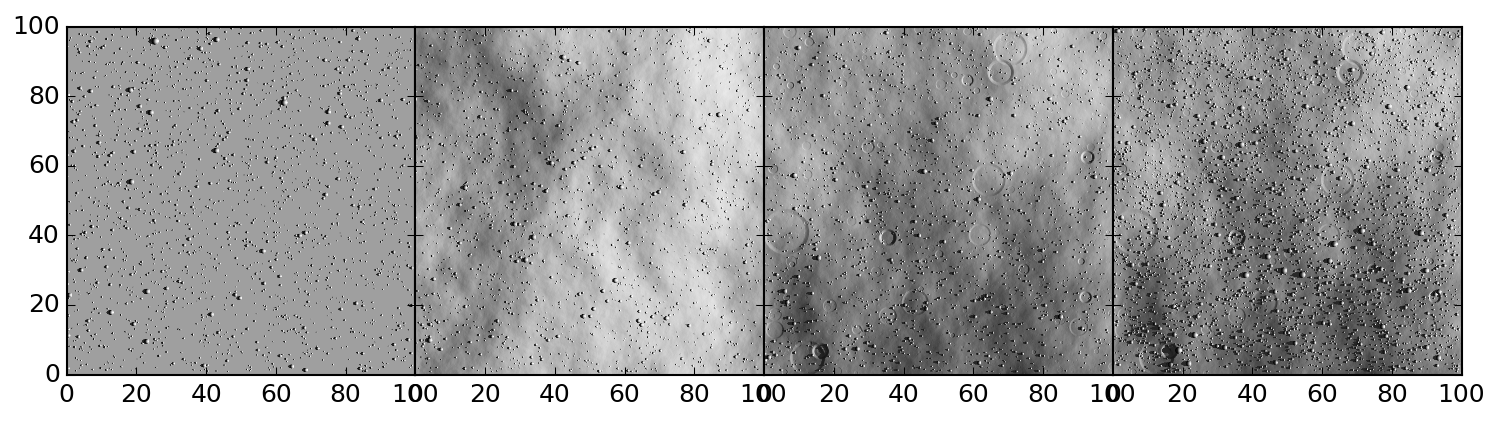

In [8]:
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 2.9)

for i, scr in enumerate(diffs):
    # Here's the data we'll plot
    pgm = read_pgm(pgm_file.format(**scr._asdict()))
    
    ax = axs[i]
    ax.imshow(pgm, cmap=mpl.cm.gray, extent=(0, 100, 0, 100))
    
fig.subplots_adjust(hspace=0, wspace=0)

## Solutions

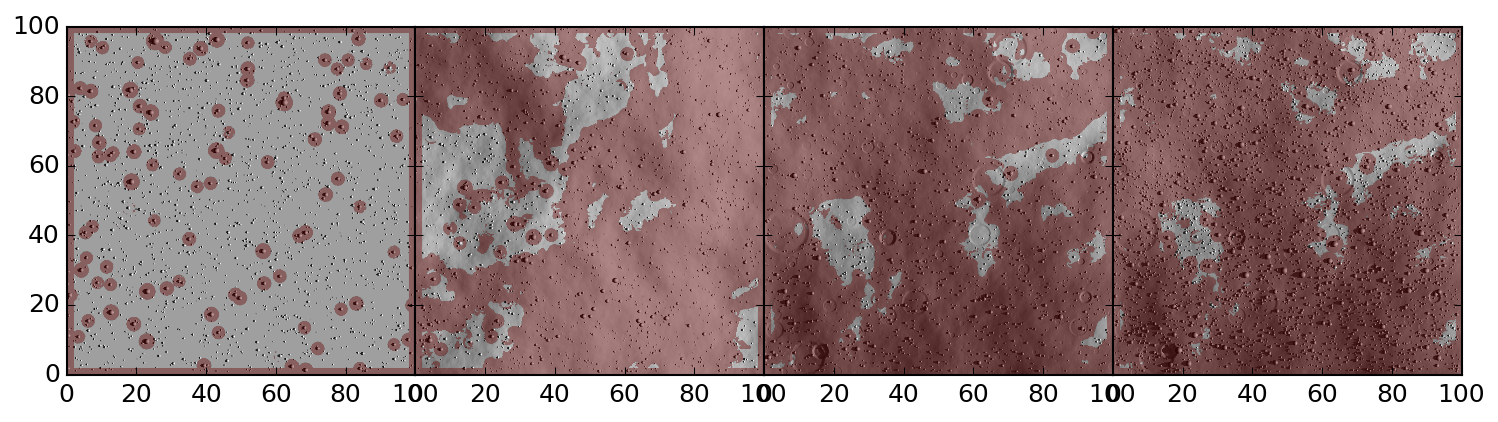

In [11]:
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 2.9)

for i, d in enumerate(diffs):
    pgm = read_pgm(pgm_file.format(slope=d.slope, crater=d.crater, rough=d.roughness))
    soln = read_pgm(soln_file.format(slope=d.slope, crater=d.crater, rough=d.roughness))
    
    soln_overlay = np.ones((soln.shape[0], soln.shape[1], 4), dtype=np.uint8) * 255
    soln_overlay[:,:,2] = soln_overlay[:,:,1] = soln  # make it red
    soln_overlay[:,:,3] = (255 - soln) * 0.4  # only color red, with alpha mask
    
    ax = axs[i]
    ax.imshow(pgm, cmap=mpl.cm.gray, extent=(0, 100, 0, 100))
    ax.imshow(soln_overlay, extent=(0, 100, 0, 100))
    
fig.subplots_adjust(hspace=0, wspace=0)

# Neural Network Basics

For our problem, we must take a set of input data, namely the height and image data about a particular landing site, and use that to classify if we can safely land in that location. To do this, we use a neural network. Here we will cover what exactly a neural network is and how we can use a neural network to perform a classification.

## Neural Nets as Linear regression

In the most simple form (no activation function, zero bias), a neural network is a fancy way of saying a complex linear mapping. That is to say we take our set of input parameters as a vector and multiply it by a matrix to map it onto the space of possible outputs, that is "safe" and "unsafe". That is we can think of mapping from the input space to the output space as:
$$y = W^{(1)}x$$
where $x$ is the input parameters, $y$ is the output, and $W^{(1)}$ is a matrix that maps from the input to the output. In our example, $x$ is the height and image data and $y$ is a two-dimensinal vector:
$$y = \begin{bmatrix} y_{safe} \\ y_{unsafe} \end{bmatrix}$$
This is termed a one-hot representation, where for classified points
\begin{align}
  \mathrm{safe}\ \Rightarrow\ y&=\begin{bmatrix} 1 \\ 0 \end{bmatrix} \\
  \mathrm{unsafe}\ \Rightarrow\ y&=\begin{bmatrix} 0 \\ 1 \end{bmatrix}
\end{align}
The idea here is for a given input, the larger of the two values will be our classification for the input. With a proper normalization, the values of $y$ can correspond to the predicted probability of each of the options. We call the $W^{(i)}$ matrices the weight matrix, and each individual element $w^{(i)}_{j,k}$ is termed the weight, which weights the influence of the $k$th element of $x$ on the $j$th element of $y$.

A schematic of this is shown below:

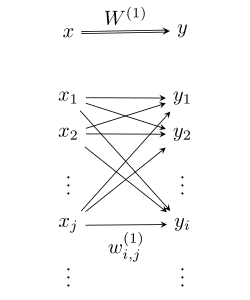

In [12]:
%%tikz -f svg -l matrix,positioning --size 250,300
\matrix (m) [matrix of math nodes, row sep=0.5em, column sep=4em]
{ x_1 & y_1 \\
  x_2 & y_2 \\
  \vdots & \vdots \\
  x_j & y_i \\
  \vdots & \vdots \\};
\path[-stealth]
  (m-1-1) edge (m-1-2)
  (m-1-1) edge (m-2-2)
  (m-1-1) edge (m-4-2)
  (m-2-1) edge (m-1-2)
  (m-2-1) edge (m-2-2)
  (m-2-1) edge (m-4-2)
  (m-4-1) edge (m-1-2)
  (m-4-1) edge (m-2-2)
  (m-4-1) edge node [below] {$w^{(1)}_{i,j}$} (m-4-2);
\node (x) [above=2em of m-1-1] {$x$}
 node (y) [above=2em of m-1-2] {$y$};
\path [-stealth]
 (x) edge [double] node [above] {$W^{(1)}$} (y);

## Adding neurons

Essentially, at this point, this is a glorified multidimensional linear regresion. Here comes the "neuron" part. What we do is break up the single matrix step into multiple matrices. In this case, what we end up with in the end is equivalent, but this step will let us do interesting things with these intermediate values.  Take in this case three matrices, so now:
$$y = W^{(3)} W^{(2)} W^{(1)} x$$

The intermediate values, which we call $h^{(i)}$ are the so called hidden layers, and each element in a hidden layer corresponds to a neuron. Our new schematic looks like:

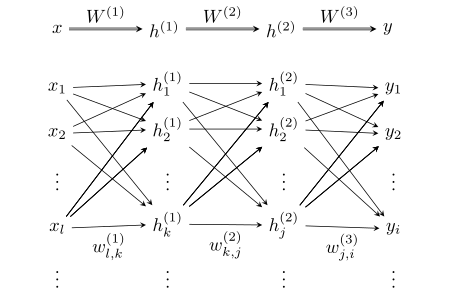

In [13]:
%%tikz -f svg -l matrix,positioning --size 450,300
\matrix (m) [matrix of math nodes, row sep=0.5em, column sep=4em]
{ x_1 & h^{(1)}_1 & h^{(2)}_1 & y_1 \\
  x_2 & h^{(1)}_2 & h^{(2)}_2 & y_2 \\
  \vdots & \vdots & \vdots & \vdots \\
  x_l & h^{(1)}_k & h^{(2)}_j & y_i \\
  \vdots & \vdots & \vdots & \vdots \\};
\foreach \i in {1,2} {
  \foreach \j in {1,2,4} {
    \path[-stealth] (m-\i-1) edge (m-\j-2)
                    (m-4-1) edge (m-\i-2)
                    (m-\i-2) edge (m-\j-3)
                    (m-4-2) edge (m-\i-3)
                    (m-\i-3) edge (m-\j-4)
                    (m-4-3) edge (m-\i-4);
  }
}
\path [-stealth]
  (m-4-1) edge node [below] {$w^{(1)}_{l,k}$} (m-4-2)
  (m-4-2) edge node [below] {$w^{(2)}_{k,j}$} (m-4-3)
  (m-4-3) edge node [below] {$w^{(3)}_{j,i}$} (m-4-4);
    
\node (x) [above=2em of m-1-1] {$x$}
 node (h1) [right=4em of x] {$h^{(1)}$}
 node (h2) [right=4em of h1] {$h^{(2)}$}
 node (y) [right=4em of h2] {$y$};
\path [-stealth]
 (x) edge [double] node [above] {$W^{(1)}$} (h1)
 (h1) edge [double] node [above] {$W^{(2)}$} (h2)
 (h2) edge [double] node [above] {$W^{(3)}$} (y);

Note that we have not specified the dimensionality of any of the intermediate vectors, such that we can have arbitrarily many hidden layers and arbitrarily many elements in each hidden layer.

## Making neurons behave like neurons

At this point, the neurons are just superflous intermediate terms in a large matrix product. Because we just have a linear regression model, there we are not able to model interesting higher order behavior. To do this, we make our hidden layers behave more like neurons.

To do this, we apply to each hidden element an activation function. The idea here is if we map a very large value onto our neuron, it turns on and contributes to the next layer, where as if a very small value is mapped onto the neuron, it turns off and does not contibute to the subsequent layer of calculation. This is how the neuron analogy works in, by properly selecting the weights, we can activate or suppress the action of certain neurons, thus leading to pathways which can enforce and suppress each other to activate one or the other output.

A classic choice of activation function is the sigmoid function. The sigmoid function is defined as:
$$S(x) = \left(1 + e^{-x}\right)^{-1}$$
The sigmoid is a nice choice because it smoothly transitions from 0 to 1.  The plot of the sigmoid looks like:

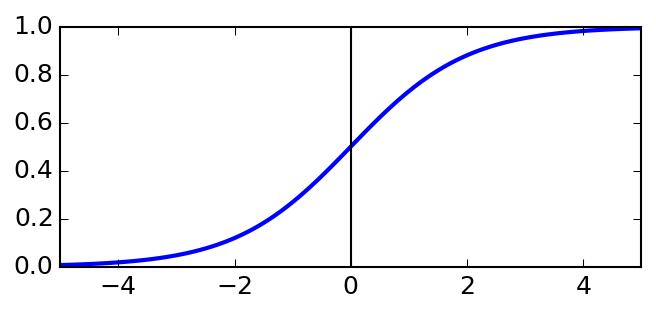

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 2)

x = np.linspace(-5, 5, 101)
y = 1 / (1 + np.exp(-x))

ax.plot(x, y, lw=2)
ax.plot([0, 0], [0, 1], 'k-')
ax.set_xlim(-5, 5)

We see that it goes to 1 in the limit $x \rightarrow \infty$, corresponding to the neuron being activated, and it goes to 0 in the limit $x \rightarrow -\infty$, corresponding to the neuron being deactivated.

A key here is that by applying this function to each neuron before we calculate the subsequent layer means we no longer have a linear function. This step of applying a non-linear function at each of the neurons is sufficient to make the neural net capable of modeling complex behavior and determining higher-order patterns in the data.

At this point, we have the following setup:

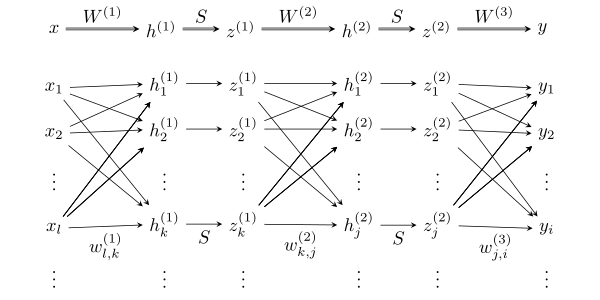

In [15]:
%%tikz -f svg -l matrix,positioning --size 600,300
\matrix (m) [matrix of math nodes, row sep=0.5em, column sep=2em]
{ x_1 && h^{(1)}_1 & z^{(1)}_1 && h^{(2)}_1 & z^{(2)}_1 && y_1 \\
  x_2 && h^{(1)}_2 & z^{(1)}_2 && h^{(2)}_2 & z^{(2)}_2 && y_2 \\
  \vdots && \vdots & \vdots && \vdots & \vdots && \vdots \\
  x_l && h^{(1)}_k & z^{(1)}_k && h^{(2)}_j & z^{(2)}_j && y_i \\
  \vdots && \vdots & \vdots && \vdots & \vdots && \vdots \\};
\foreach \i in {1,2} {
  \path[-stealth] (m-\i-3) edge (m-\i-4)
                  (m-\i-6) edge (m-\i-7);
  \foreach \j in {1,2,4} {
    \path[-stealth] (m-\i-1) edge (m-\j-3)
                    (m-4-1) edge (m-\i-3)
                    (m-\i-4) edge (m-\j-6)
                    (m-4-4) edge (m-\i-6)
                    (m-\i-7) edge (m-\j-9)
                    (m-4-7) edge (m-\i-9);
  }
}
\path[-stealth]
  (m-4-1) edge node [below] {$w^{(1)}_{l,k}$} (m-4-3)
  (m-4-3) edge node [below] {$S$} (m-4-4)
  (m-4-4) edge node [below] {$w^{(2)}_{k,j}$} (m-4-6)
  (m-4-6) edge node [below] {$S$} (m-4-7)
  (m-4-7) edge node [below] {$w^{(3)}_{j,i}$} (m-4-9);
 
\node (x) [above=2em of m-1-1] {$x$}
 node (h1) [right=4em of x] {$h^{(1)}$}
 node (z1) [right=2em of h1] {$z^{(1)}$}
 node (h2) [right=4em of z1] {$h^{(2)}$}
 node (z2) [right=2em of h2] {$z^{(2)}$}
 node (y) [right=4em of z2] {$y$};
\path [-stealth]
 (x) edge [double] node [above] {$W^{(1)}$} (h1)
 (h1) edge [double] node [above] {$S$} (z1)
 (z1) edge [double] node [above] {$W^{(2)}$} (h2)
 (h2) edge [double] node [above] {$S$} (z2)
 (z2) edge [double] node [above] {$W^{(3)}$} (y);

## Adding a bias

The final step is to add a bias to each of the neurons.  This bias value sets the default behavior of the neuron, whether it defaults to be more or less activated. Using the matrix notation from above, we can say a hidden layer $i$ is assigned a vector of bias values $b^{(i)}_j$ which adds to the $h^{(i)}_j$ value before the activation is computed.  Calling the activation of the $i$th hidden layer as $z^{(i)}$, adopting the above matrix convention, the final expression for the activation of a hidden layer is:
$$ z^{(i)} = S\left(W^{(i)} z^{(i-1)} + b^{(i)}\right)$$
where the sigmoid function, $S$, is applied element-wise.  In this expression, the final output $y$ is computed in the same way using the last hidden layer as $z^{(i-1)}$, and we can think of the input data $x$ as being the $z^{(0)}$ activation.

The final graphical representation of this is:

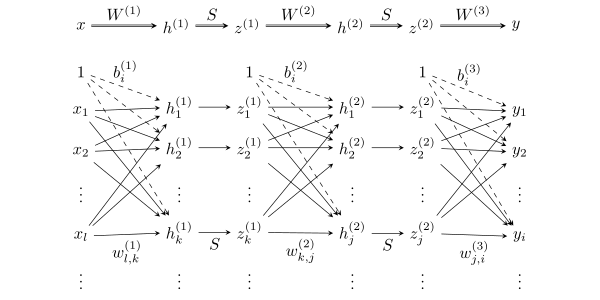

In [16]:
%%tikz -f svg -l matrix,positioning --size 600,300
\matrix (m) [matrix of math nodes, row sep=0.5em, column sep=2em]
{ 1 &&& 1 &&& 1 && \\
  x_1 && h^{(1)}_1 & z^{(1)}_1 && h^{(2)}_1 & z^{(2)}_1 && y_1 \\
  x_2 && h^{(1)}_2 & z^{(1)}_2 && h^{(2)}_2 & z^{(2)}_2 && y_2 \\
  \vdots && \vdots & \vdots && \vdots & \vdots && \vdots \\
  x_l && h^{(1)}_k & z^{(1)}_k && h^{(2)}_j & z^{(2)}_j && y_i \\
  \vdots && \vdots & \vdots && \vdots & \vdots && \vdots \\};
\foreach \i in {2,3} {
  \path[-stealth] (m-\i-3) edge (m-\i-4)
                  (m-\i-6) edge (m-\i-7)
                  (m-5-1) edge (m-\i-3)
                  (m-5-4) edge (m-\i-6)
                  (m-5-7) edge (m-\i-9);
  \foreach \j in {2,3,5} {
    \path[-stealth] (m-\i-1) edge (m-\j-3)
                    (m-\i-4) edge (m-\j-6)
                    (m-\i-7) edge (m-\j-9);
  }
}

\foreach \i in {3,5} {
  \path[-stealth,dashed] (m-1-1) edge (m-\i-3)
                         (m-1-4) edge (m-\i-6)
                         (m-1-7) edge (m-\i-9);
}

\path[-stealth,dashed] (m-1-1) edge node [above] {$b^{(1)}_i$} (m-2-3)
                       (m-1-4) edge node [above] {$b^{(2)}_i$} (m-2-6)
                       (m-1-7) edge node [above] {$b^{(3)}_i$} (m-2-9);

\path[-stealth]
  (m-5-1) edge node [below] {$w^{(1)}_{l,k}$} (m-5-3)
  (m-5-3) edge node [below] {$S$} (m-5-4)
  (m-5-4) edge node [below] {$w^{(2)}_{k,j}$} (m-5-6)
  (m-5-6) edge node [below] {$S$} (m-5-7)
  (m-5-7) edge node [below] {$w^{(3)}_{j,i}$} (m-5-9);
 
\node (x) [above=4em of m-2-1] {$x$}
 node (h1) [right=4em of x] {$h^{(1)}$}
 node (z1) [right=2em of h1] {$z^{(1)}$}
 node (h2) [right=4em of z1] {$h^{(2)}$}
 node (z2) [right=2em of h2] {$z^{(2)}$}
 node (y) [right=4em of z2] {$y$};
\path [-stealth]
 (x) edge [double] node [above] {$W^{(1)}$} (h1)
 (h1) edge [double] node [above] {$S$} (z1)
 (z1) edge [double] node [above] {$W^{(2)}$} (h2)
 (h2) edge [double] node [above] {$S$} (z2)
 (z2) edge [double] node [above] {$W^{(3)}$} (y);

## Adding a softmax layer

At the end, we have some vector of outputs $y$, but these are not normalized in any meaningful way. In order to normalize and assign probabilities, we add what is called a softmax layer. To draw a statistical mechanics analogy that physicists will appreciate, we can take the output we have computed to be something like an energy state, $-E$, of a system. At this point, we can compute the probability for a system to be in any one of the given states with the Boltzmann distribution.  For some given inputs, $x$, we can assign probabilities to each of the output states as:
$$p_i(x) = \frac{e^{y_i(x)}}{\sum_i e^{y_i(x)}}$$
where the $y_i(x)$ are the values computed above.

## Assessing goodness of fit

The next thing we want is to make our neural net good at making predictions, but first we need some way to say how good the neural network performs. To do this we use what is called the negative log-likelihood. Neural nets are a supervised learning technique, so they require a labeled data set to train the parameters. For a given test case with some input data $x$ and known classification $Y$ which we take to be the $i$ category, the likelihood of this given by the neural net is:
$$p(Y|x) = p_i(x)$$
If we have a sample of input data $x^{(i)}$ each with a known classification $Y^{(i)}$, the likelihood for this is the product
$$P(Y^{(1)}|x^{(1)}),\dotsc) = \prod_i p(Y^{(i)}|x^{(i)})$$
In order to make the math nice, we use the $\log$ function; because $\log$ is monotonic, a larger value of the likelihood will give a larger value of the log-likelihood.  We use the log because:
$$\log \prod_i p(Y^{(i)}|x^{(i)}) = \sum_i \log p(Y^{(i)}|x^{(i)})$$
This simplifies the following calculation, as each test case contributes individually to the total log-likelihood.  Because we want to maximize the log-likelihood, we minimize the negative log-likelihood.  This then is the same as minimizing the cross entropy of the system.

## Minimizing NLL

To minimize the negative log-likelihood, we use what is called gradient descent.  Basically, for a given input $x$, we have a function which takes as parameters all of the weights and baises and returns the probabilities which give the NLL.  Because we want to minimize the NLL, we can compute the gradient of the NLL with respect to the weight parameters and adjust the weights appopriately. That is:
$$w^{(i)}_{j,k} := w^{(i)}_{j,k} - \eta \frac{\partial}{\partial w^{(i)}_{j,k}}\left[\sum_i \log p(Y^{(i)}|x^{(i)})\right]$$
where $\eta$ is an adjustable learning rate.

# Optimizing training

In order to effectively train on large data sets, we employ several techniques that reduce the computational cast of training while not reducing training ability.

## Rectified Linear Activation

First, while the sigmoid is a very nice function for thinking about the intuition behind a neural network and has nice smoothness properties allowing us to define the derivative for the computation of the gradient, it is computationaly expensive. Instead, we use a rectified linear activation function, which has a profile:

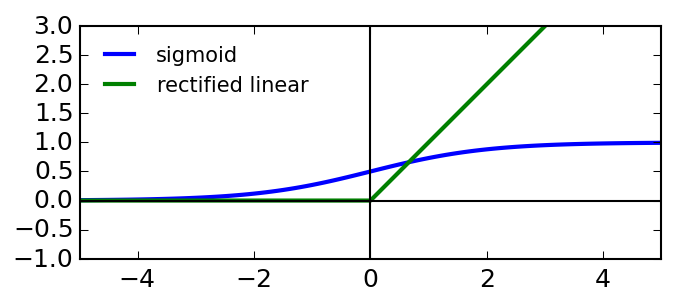

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 2)

x = np.linspace(-5, 5, 101)
y1 = 1 / (1 + np.exp(-x))
y2 = np.maximum(x, 0)

plt.plot(x, y1, label='sigmoid', lw=2)
plt.plot(x, y2, label='rectified linear', lw=2)
ax.plot([0, 0], [-1, 3], 'k-')
ax.plot([-5, 5], [0, 0], 'k-')
ax.set_xlim(-5, 5)
ax.set_ylim(-1, 3)
ax.set_aspect('equal')
ax.legend(loc=2, fontsize=10).draw_frame(False)

This greatly reduces the computation of both the activation of the neuron and the computation of the gradient.  This method also does not reduce the training ability of the neural net.

## Max norm

A very important concept in machine learning is normalization. Because of the potentially very large number of parameters in setting up the hidden layers, we can fit arbitrarily well to a given data set, but the resulting neural network does not generalize well to other data sets.  In order to prevent this from happening, we make sure the values of the weights do not become too large.  One way to do this is to add a cost proportional to the norm of the weight matrices to the NLL cost function. Another more computationally simple method is to enforce a maximum to the norm of the weight matrices. This has a similar effect to adding a cost to the weight norm.

## Dropout

Another normalization technique we implement is dropout.  To do this, on each iteration of training, a randomly selected selection of weights are temporarily zeroed. This has the dual effect of simplifying the computation, as each iteration only considers a subset of the neurons, and improves the training of the net. The basic idea behind dropout is to promote multiple independently reinforced pathways to activate the necessary neurons for each classification.

## Stochastic Gradient Descent

When running the gradient descent algorithm, we need to compute the contribution to the gradient from every training data point. For very large training data sets, this can take a very long time. In order to speed up learning, we can consider only a subset of the training data. By partitioning this data into batches and approximate the full gradient by the gradient of the batch, we can speed up learning. This is called stochastic gradient descent. When doing this, we no longer have guarantee that the changes to the weights will lower the total cost function, but by iterating over the entire training data set, we get a good approximation.

## Momentum

One we to mitigate some of the problems of stochastic gradient descent is to use momentum, which is basically to add the previous computed gradient to the current gradient term when performing gradient descent. This basically gives a memory to the gradient term, so that the gradient computed for other terms aren't totally neglected. In addition to smoothing out the stochastic descent, using momentum helps the gradient descent algorithm move through areas in parameter space where the cost either plateaus and keeps the gradient descent from getting stuck in local minima.

## Changing learning rate

As we learn, we adapt the learning rate parameter, denoted $\eta$ above. A large learning rate are best early to quickly move the parameters towards the minimum value. However, as we approach a final configuration, we want to slow the learning rate so we do not overshoot the optimal location.  To do this, we simply scale the learning rate down with each iteration of gradient descent.

# The Plan

**Try to classify by brute force, anything that is sufficiently safe (>=0.9 m clearance, <8° tilt for configurations) is safe, grossly unsafe (0.2 m into base, >13° tilt) marked unsafe, everything else fed into neural net**

# Processing Data

For each data set, we have almost 1 million data points to work with, now we need to construct the input data for each input point. each landing site has the points of roughly:

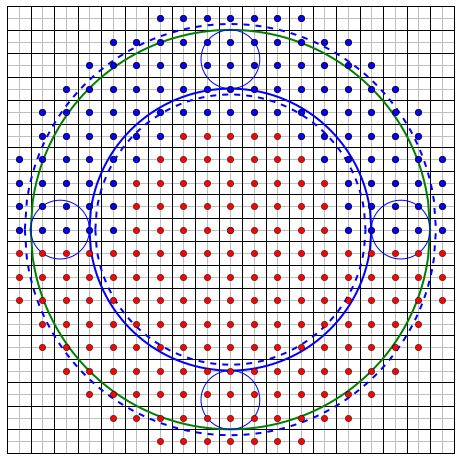

In [46]:
# Parameters for lander
r = 17
r_foot = 2.5

# How to extract positions under the feet
x = np.arange(-18, 19, 2)
y = np.arange(0, 19, 2)
X_foot, Y_foot = np.meshgrid(x, y)
sel_foot = np.logical_and(X_foot**2 + Y_foot**2 >= (r - (2 * r_foot + 2))**2,
                          X_foot**2 + Y_foot**2 <= (r + 2)**2)

# Distance between foot positions
spacing = 0.1
x = -X_foot[sel_foot] * spacing
y = -Y_foot[sel_foot] * spacing
run = np.sqrt((2*x)**2 + (2*y)**2)

# How to extract positions under the base
x = np.arange(-18, 19, 2)
y = np.arange(-18, 19, 2)
X_base, Y_base = np.meshgrid(x, y)
sel_base = X_base**2 + Y_base**2 <= (r + 2)**2

fig, ax = plt.subplots(figsize=(8, 8))

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlim(-19, 19)
ax.set_ylim(-19, 19)

ax.plot(0, 0, 'ok')

for i in np.arange(-18, 19):
    ax.plot([-19, 19], [i, i], '-', color='0.75')
    ax.plot([i, i], [-19, 19], '-', color='0.75')

for i in np.arange(-17, 19, 2):
    ax.plot([-19, 19], [i, i], 'k-')
    ax.plot([i, i], [-19, 19], 'k-')

x = np.linspace(-r, r, 200)
y = np.sqrt(r**2 - x**2)

ax.plot(x, y, 'g-', lw=2)
ax.plot(x, -y, 'g-', lw=2)

x = np.linspace(r - 2 * r_foot, r, 100)
y = np.sqrt(r_foot**2 - (x - (r - r_foot))**2)

ax.plot(x, y, 'b-', lw=1)
ax.plot(x, -y, 'b-', lw=1)

ax.plot(-x, y, 'b-', lw=1)
ax.plot(-x, -y, 'b-', lw=1)

ax.plot(y, x, 'b-', lw=1)
ax.plot(-y, x, 'b-', lw=1)

ax.plot(y, -x, 'b-', lw=1)
ax.plot(-y, -x, 'b-', lw=1)

x = np.linspace(-(r - 2 * r_foot), (r - 2 * r_foot), 200)
y = np.sqrt((r - 2 * r_foot)**2 - x**2)

ax.plot(x, y, 'b-', lw=2)
ax.plot(x, -y, 'b-', lw=2)

x = np.linspace(-(r + 0.5), (r + 0.5), 200)
y = np.sqrt((r + 0.5)**2 - x**2)

ax.plot(x, y, 'b--', lw=2)
ax.plot(x, -y, 'b--', lw=2)

x = np.linspace(-(r - 2 * r_foot - 0.5), (r - 2 * r_foot - 0.5), 200)
y = np.sqrt((r - 2 * r_foot - 0.5)**2 - x**2)

ax.plot(x, y, 'b--', lw=2)
ax.plot(x, -y, 'b--', lw=2)

ax.plot(X_base[sel_base], Y_base[sel_base], 'ro')
ax.plot(X_foot[sel_foot], Y_foot[sel_foot], 'bo')

Some general functions we'll use for all cases. Here, we also see the pickle format that pylearn2 requires.

In [4]:
r = 17  # in units of 0.2 m
x = np.arange(-20, 21, 2)
y = np.arange(-20, 21, 2)
X_base, Y_base = np.meshgrid(x, y)

# Locations that must be checked for unsafe classification
sel_base_unsafe = X_base**2 + Y_base**2 <= r**2

# Locations that must be checked for safe classification
sel_base_safe = X_base**2 + Y_base**2 <= (r + 4)**2

In [95]:
# sentinels, where unsafe = 0, safe = 255 (to match pgm)
UNSAFE, UNKNOWN, SAFE = 0x00, 0xff // 2, 0xff

pickle_x_train = os.path.join(output_dir, "X_train.pkl")
pickle_x_test = os.path.join(output_dir, "X_test.pkl")
pickle_y_train = os.path.join(output_dir, "y_train.pkl")
pickle_y_test = os.path.join(output_dir, "y_test.pkl")

preprocessing_pgm = os.path.join(output_dir, "out_preprocessing_S{slope}C{crater}R{roughness}.pgm")
final_pgm = os.path.join(output_dir, "out_final_S{slope}C{crater}R{roughness}.pgm")

# shape of the height data
height_rows = height_cols = 500
# we'll automatically fail an edge of 21 points around the landing zone
edge_buffer = 21

# Dimensions of lander to number of height points
ncols = 21
# Dimensions of lander to number of image points
nn_window = 35

# Number of features we'll feed in
nn_feat = nn_window**2

def generate_nn_input(scr, selection, solution, image):
    # generate a comparison file
    cmp_file = os.path.join(output_dir, "preprocessed.png").format(**scr._asdict())
    compare_guesses(selection, solution, image, cmp_file)
    
    # Figure out how much to feed into net
    n_safe = np.sum(np.logical_and(selection == UNKNOWN, solution == SAFE))
    n_unsafe = np.sum(np.logical_and(selection == UNKNOWN, solution == UNSAFE))
    # and allocate some arrays for it
    output_safe = np.empty((n_safe, nn_feat), dtype=np.float32)
    output_unsafe = np.empty((n_unsafe, nn_feat), dtype=np.float32)
    
    row, col = np.indices((solution.shape))
    # Populate each array
    sel = np.logical_and(selection == UNKNOWN, solution == SAFE)
    rows, cols = row[sel].flatten(), col[sel].flatten()
    for n, (i, j) in enumerate(zip(rows, cols)):
        output_safe[n, :] = image[i-nn_window//2-1:i+nn_window//2,
                                  j-nn_window//2-1:j+nn_window//2].flatten()
    
    sel = np.logical_and(selection == UNKNOWN, solution == UNSAFE)
    rows, cols = row[sel].flatten(), col[sel].flatten()
    for n, (i, j) in enumerate(zip(rows, cols)):
        output_unsafe[n, :] = image[i-nn_window//2-1:i+nn_window//2,
                                    j-nn_window//2-1:j+nn_window//2].flatten()
    
    # Normalize output
    output_safe = (output_safe - 159) / 256
    output_unsafe = (output_unsafe - 159) / 256
    
    print("Generated {:d} safe and {:d} unsafe training data points".format(n_safe, n_unsafe))
    return output_safe, output_unsafe

def create_pickle(scr, output_safe, output_unsafe):
    n_safe = output_safe.shape[0]
    n_unsafe = output_unsafe.shape[0]
    
    n_train_safe = int(0.9 * n_safe)
    n_train_unsafe = int(0.9 * n_unsafe)
    n_test_safe = n_safe - n_train_safe
    n_test_unsafe = n_unsafe - n_train_unsafe
    
    # XXX IS THIS GOOD TO DO???
    # n_train_safe = int(0.9 * min(n_safe, n_unsafe))
    # n_test_safe = min(n_safe, n_unsafe) - n_train
    
    print("Saving data... ", end="")
    X_train = np.vstack([
        output_safe[:n_train_safe, :],
        output_unsafe[:n_train_unsafe, :]
    ])
    X_test = np.vstack([
        output_safe[n_train_safe:n_train_safe+n_test_safe, :],
        output_unsafe[n_train_unsafe:n_train_unsafe+n_test_unsafe, :]
    ])

    y_train = np.vstack([
        np.ones((n_train_safe, 1), dtype=int),
        np.zeros((n_train_unsafe, 1), dtype=int),
    ])
    y_test = np.vstack([
        np.ones((n_test_safe, 1), dtype=int),
        np.zeros((n_test_unsafe, 1), dtype=int),
    ])

    serial.save(pickle_x_train.format(**scr._asdict()), X_train)
    serial.save(pickle_x_test.format(**scr._asdict()), X_test)
    serial.save(pickle_y_train.format(**scr._asdict()), y_train)
    serial.save(pickle_y_test.format(**scr._asdict()), y_test)
    print("done")

## No slopes

The easiest data set has no slopes, and so the slope hazards do not need to be taken into consideration.  For this, we only need to look at the points within the above area around any point and check the heights of the points.

In [68]:
# limits for defining safe/unsafe
height_safe = 0.29
height_unsafe = 0.39

def preprocess_noslopes(scr):
    # Read in the data and make a value for outputs
    height = read_raw(raw_file.format(**scr._asdict()), height_rows, height_cols)
    # Read in the image
    image = read_pgm(pgm_file.format(**scr._asdict()))
    # Read in the solution
    soln = read_pgm(soln_file.format(**scr._asdict()))
    
    # Compute the safe/unsafe/unknown landing sites
    gen_output = compute_noslopes(height)
    
    # double the selection matrix in each dimension
    gen_output = np.hstack((gen_output, gen_output)).reshape((-1, 1))
    gen_output = np.hstack((gen_output, gen_output)).reshape(soln.shape)
    # fix the edge of the selection
    gen_output[:edge_buffer, :] = UNSAFE
    gen_output[-edge_buffer:, :] = UNSAFE
    gen_output[:, :edge_buffer] = UNSAFE
    gen_output[:, -edge_buffer] = UNSAFE
    
    # Write the output
    write_pgm(gen_output, preprocessing_pgm.format(**scr._asdict()))
    
    # Create the NN input
    df_safe, df_unsafe = generate_nn_input(scr, gen_output, soln, image)
    
    # Generate the NN input pickle
    create_pickle(scr, df_safe, df_unsafe)

def compute_noslopes(height):# Initialize fully unsafe values
    output = np.zeros_like(height, dtype=np.uint8)
    for i in range(edge_buffer // 2, height_cols - edge_buffer // 2):
        for j in range(edge_buffer // 2, height_rows - edge_buffer // 2):
            z = height[i-ncols//2:i+ncols//2+1, j-ncols//2:j+ncols//2+1]
            
            # Check if all in large radius is safe
            z_safe = z[sel_base_safe]
            if (np.max(z_safe) - np.min(z_safe)) < height_safe:
                output[i, j] = SAFE
                continue
            
            # Check if any in small radius has any unsafe
            z_unsafe = z[sel_base_unsafe]
            if (np.max(z_unsafe) - np.min(z_unsafe)) > height_unsafe:
                output[i, j] = UNSAFE
                continue
            
            output[i, j] = UNKNOWN
    return output

In [69]:
# Just use the easiest one
scr = diffs[0]

out = output_dir.format(**scr._asdict())
if not os.path.exists(out):
    os.makedirs(out)

preprocess_noslopes(scr)

Accuracy:          100.0%
F1 (safe):         1.00
F1 (unsafe):       1.00

Safe classification accuracy:   100.0% (670989 / 670989)
Unsafe classification accuracy: 100.0% (151352 / 151352)

Unknown safe:   75.9% (134907 / 177659)
Unknown unsafe: 24.1% (42752 / 177659)
Generated 134907 safe and 42752 unsafe training data points
Saving data... done


![](../Sean/nn_files_S0C0R10/preprocessed.png)

## With slopes

For slope considerations, we implemented a rudimentary checker that iterated over all possible triplets of landing foot positions and checked if any height would collide with it in this configuration. The entirety of this algorithm uses big matrix multiplication to do the coordinate transformation to bring the triplet of and checking for large values , and would have been super easy with numpy, but our original implementation in C++ is complex, but it is tested. I ran out of time to re-implement it in Python here, so we'll just call the compiled versions.

The required output from the C code is included in the git directory, so if you cannot compile or run this, you can comment out the subprocess call and it will read in the needed pgm output file.

In [60]:
gen_full_executable = os.path.abspath(os.path.join("..", "Sean", "src", "gen_full"))

if os.name == 'nt':
    gen_full_executable += ".exe"

output_nn = os.path.join(output_dir, "nn_outS{slope}C{crater}R{roughness}")

def preprocess_slopes(scr):
    # Read in the data and make a value for outputs
    height = read_raw(raw_file.format(**scr._asdict()), height_rows, height_cols)
    # Read in the image
    image = read_pgm(pgm_file.format(**scr._asdict()))
    # Read in the solution
    soln = read_pgm(soln_file.format(**scr._asdict()))
    
    subprocess.check_call([gen_full_executable,
                           raw_file.format(**scr._asdict()),
                           pgm_file.format(**scr._asdict()),
                           soln_file.format(**scr._asdict()),
                           output_pgm.format(**scr._asdict()),
                           output_nn.format(**scr._asdict())])
    
    # Read the comparison file in
    gen_output = read_pgm(preprocessing_pgm.format(**scr._asdict()))
    
    # Create the NN input
    df_safe, df_unsafe = generate_nn_input(scr, gen_output, soln, image)
    
    # Generate the NN input pickle
    create_pickle(scr, df_safe, df_unsafe)

In [63]:
preprocess_slopes(diffs[1])

Accuracy:          99.3%
F1 (safe):          nan
F1 (unsafe):       1.00

Safe classification accuracy:    0.0% (0 / 5105)
Unsafe classification accuracy: 100.0% (678466 / 678466)

Unknown safe:   67.3% (213077 / 316429)
Unknown unsafe: 32.7% (103352 / 316429)
Generated 213077 safe and 103352 unsafe training data points
Saving data... done


![](../Sean/nn_files_S4C0R10/preprocessed.png)

In [64]:
preprocess_slopes(diffs[2])

Accuracy:          99.4%
F1 (safe):          nan
F1 (unsafe):       1.00

Safe classification accuracy:    0.0% (0 / 4624)
Unsafe classification accuracy: 100.0% (752105 / 752105)

Unknown safe:   49.2% (119728 / 243271)
Unknown unsafe: 50.8% (123543 / 243271)
Generated 119728 safe and 123543 unsafe training data points
Saving data... done


![](../Sean/nn_files_S4C4R10/preprocessed.png)

In [65]:
preprocess_slopes(diffs[3])

Accuracy:          99.0%
F1 (safe):          nan
F1 (unsafe):       0.99

Safe classification accuracy:    0.0% (0 / 8821)
Unsafe classification accuracy: 100.0% (838391 / 838391)

Unknown safe:   50.8% (77644 / 152788)
Unknown unsafe: 49.2% (75144 / 152788)
Generated 77644 safe and 75144 unsafe training data points
Saving data... done


![](../Sean/nn_files_S4C4R20/preprocessed.png)

# Using Pylearn2

In order to train our net, we used [pylearn2](https://github.com/lisa-lab/pylearn2), a deep learning library based on Theano.  We did this because pylearn2 provides many tools for seting up and configuring neural networks, and also provides all of the functionality and optimizations outlined above.

While experiments with pylearn2 can be constructed programatically, pylearn2 provides a means of writing neural network configurations, which includes configuring and setting up the input data, the structure of the network, and the method of training.  These files can then be run by pylearn2. While we write what would be in the files into a string and pass that into pylearn2, you also have the option to call a pylearn2 script that would read in a file from your file system. In order to quickly and easily run our training, we chose to use the yaml configuration files to do our training.

The yaml file we used is given below, note all of the tricks noted above to aid the training are implemented in the configuration.

In [11]:
yaml = """\
!obj:pylearn2.train.Train {{{{
    dataset: &train !obj:pylearn2.datasets.dense_design_matrix.DenseDesignMatrix {{{{
        X: !pkl: '{x_train}',
        y: !pkl: '{y_train}',
        y_labels: 2,
    }}}},

    model: !obj:pylearn2.models.mlp.MLP {{{{
        # Setup the NN, 3 RLU hidden layers and 1 output (softmax) layer
        layers : [
            !obj:pylearn2.models.mlp.RectifiedLinear {{{{
                layer_name: 'h0',
                dim: 500,
                sparse_init: 15,
                # Rather than using weight decay, we constrain the norms of the weight vectors
                max_col_norm: {max_norm}
            }}}},
            !obj:pylearn2.models.mlp.RectifiedLinear {{{{
                layer_name: 'h1',
                dim: 500,
                sparse_init: 15,
                # Rather than using weight decay, we constrain the norms of the weight vectors
                max_col_norm: {max_norm}
            }}}},
            !obj:pylearn2.models.mlp.RectifiedLinear {{{{
                layer_name: 'h2',
                dim: 500,
                sparse_init: 15,
                # Rather than using weight decay, we constrain the norms of the weight vectors
                max_col_norm: {max_norm}
            }}}},
            !obj:pylearn2.models.mlp.Softmax {{{{
                layer_name: 'y',
                n_classes: 2,
                irange: 0,
                init_bias_target_marginals: *train
            }}}},
        ],
        nvis: {n_features},
    }}}},

    # We train using stochastic gradient descent
    algorithm: !obj:pylearn2.training_algorithms.sgd.SGD {{{{
        batch_size: 100,

        learning_rate: 1e-1,
        learning_rule: !obj:pylearn2.training_algorithms.learning_rule.Momentum {{{{
            init_momentum: 0.5,
        }}}},

        # We monitor how well we're doing during training on a validation set
        monitoring_dataset: {{{{
            'train' : *train,
            'valid' : !obj:pylearn2.datasets.dense_design_matrix.DenseDesignMatrix {{{{
                X: !pkl: '{x_test}',
                y: !pkl: '{y_test}',
                y_labels: 2,
            }}}},
        }}}},

        # Use dropout to help normalization
        cost: !obj:pylearn2.costs.mlp.dropout.Dropout {{{{
            input_include_probs: {{{{
                'h0' : 0.5,
                'h1' : 0.5,
                'h2' : 0.5,
                'y'  : 1.
            }}}},
        }}}},

        # We stop if we don't improve after 10 epochs
        termination_criterion: !obj:pylearn2.termination_criteria.MonitorBased {{{{
            channel_name: "valid_y_misclass",
            prop_decrease: 0.001,
            N: 10
        }}}},
    }}}},

    # We save the model whenever we improve on the validation set classification error
    extensions: [
        # Save the "best" net (based on validation set), form of early stopping to prevent overfitting
        !obj:pylearn2.train_extensions.best_params.MonitorBasedSaveBest {{{{
             channel_name: 'valid_y_misclass',
             save_path: '{save_file_best}'
        }}}},
        # http://daemonmaker.blogspot.com/2014/12/monitoring-experiments-in-pylearn2.html
        #!obj:pylearn2.train_extensions.live_monitoring.LiveMonitoring {{{{}}}},
        !obj:pylearn2.training_algorithms.learning_rule.MomentumAdjustor {{{{
            start: 1,
            saturate: 100,
            final_momentum: .1
        }}}},
        !obj:pylearn2.training_algorithms.sgd.LinearDecayOverEpoch {{{{
            start: 1,
            saturate: 100,
            decay_factor: 1e-3
        }}}},
    ],

    save_path: '{save_file}',
    save_freq: 1,
}}}}
"""

def run_pylearn(scr):
    yaml_in = yaml.format(
        n_features=nn_feat,
        max_norm=0.75,
        save_file=os.path.join(output_dir, "nn_train.pkl"),
        save_file_best=os.path.join(output_dir, "nn_train_best.pkl"),
        x_train=pickle_x_train,
        x_test=pickle_x_test,
        y_train=pickle_y_train,
        y_test=pickle_y_test
    ).format(**scr._asdict())
    train = yaml_parse.load(yaml_in)
    train.main_loop()

With this pylearn2 configuration, we then train each of the four neural nets.

## S0 C0 R10

In [12]:
run_pylearn(diffs[0])

Parameter and initial learning rate summary:
	h0_W: 0.1
	h0_b: 0.1
	h1_W: 0.1
	h1_b: 0.1
	h2_W: 0.1
	h2_b: 0.1
	softmax_b: 0.1
	softmax_W: 0.1
Compiling sgd_update...
Compiling sgd_update done. Time elapsed: 0.716071 seconds
compiling begin_record_entry...
compiling begin_record_entry done. Time elapsed: 0.234023 seconds
Monitored channels: 
	learning_rate
	momentum
	total_seconds_last_epoch
	train_h0_col_norms_max
	train_h0_col_norms_mean
	train_h0_col_norms_min
	train_h0_max_x_max_u
	train_h0_max_x_mean_u
	train_h0_max_x_min_u
	train_h0_mean_x_max_u
	train_h0_mean_x_mean_u
	train_h0_mean_x_min_u
	train_h0_min_x_max_u
	train_h0_min_x_mean_u
	train_h0_min_x_min_u
	train_h0_range_x_max_u
	train_h0_range_x_mean_u
	train_h0_range_x_min_u
	train_h0_row_norms_max
	train_h0_row_norms_mean
	train_h0_row_norms_min
	train_h1_col_norms_max
	train_h1_col_norms_mean
	train_h1_col_norms_min
	train_h1_max_x_max_u
	train_h1_max_x_mean_u
	train_h1_max_x_min_u
	train_h1_mean_x_max_u
	train_h1_mean_x_me

## S4 C0 R10

In [117]:
run_pylearn(diffs[1])

Parameter and initial learning rate summary:
	h0_W: 0.1
	h0_b: 0.1
	h1_W: 0.1
	h1_b: 0.1
	h2_W: 0.1
	h2_b: 0.1
	softmax_b: 0.1
	softmax_W: 0.1
Compiling sgd_update...
Compiling sgd_update done. Time elapsed: 0.816082 seconds
compiling begin_record_entry...
compiling begin_record_entry done. Time elapsed: 0.231023 seconds
Monitored channels: 
	learning_rate
	momentum
	total_seconds_last_epoch
	train_h0_col_norms_max
	train_h0_col_norms_mean
	train_h0_col_norms_min
	train_h0_max_x_max_u
	train_h0_max_x_mean_u
	train_h0_max_x_min_u
	train_h0_mean_x_max_u
	train_h0_mean_x_mean_u
	train_h0_mean_x_min_u
	train_h0_min_x_max_u
	train_h0_min_x_mean_u
	train_h0_min_x_min_u
	train_h0_range_x_max_u
	train_h0_range_x_mean_u
	train_h0_range_x_min_u
	train_h0_row_norms_max
	train_h0_row_norms_mean
	train_h0_row_norms_min
	train_h1_col_norms_max
	train_h1_col_norms_mean
	train_h1_col_norms_min
	train_h1_max_x_max_u
	train_h1_max_x_mean_u
	train_h1_max_x_min_u
	train_h1_mean_x_max_u
	train_h1_mean_x_me

## S4 C4 R10

In [118]:
run_pylearn(diffs[2])

Parameter and initial learning rate summary:
	h0_W: 0.1
	h0_b: 0.1
	h1_W: 0.1
	h1_b: 0.1
	h2_W: 0.1
	h2_b: 0.1
	softmax_b: 0.1
	softmax_W: 0.1
Compiling sgd_update...
Compiling sgd_update done. Time elapsed: 0.639604 seconds
compiling begin_record_entry...
compiling begin_record_entry done. Time elapsed: 0.234002 seconds
Monitored channels: 
	learning_rate
	momentum
	total_seconds_last_epoch
	train_h0_col_norms_max
	train_h0_col_norms_mean
	train_h0_col_norms_min
	train_h0_max_x_max_u
	train_h0_max_x_mean_u
	train_h0_max_x_min_u
	train_h0_mean_x_max_u
	train_h0_mean_x_mean_u
	train_h0_mean_x_min_u
	train_h0_min_x_max_u
	train_h0_min_x_mean_u
	train_h0_min_x_min_u
	train_h0_range_x_max_u
	train_h0_range_x_mean_u
	train_h0_range_x_min_u
	train_h0_row_norms_max
	train_h0_row_norms_mean
	train_h0_row_norms_min
	train_h1_col_norms_max
	train_h1_col_norms_mean
	train_h1_col_norms_min
	train_h1_max_x_max_u
	train_h1_max_x_mean_u
	train_h1_max_x_min_u
	train_h1_mean_x_max_u
	train_h1_mean_x_me

## S4 C4 R20

In [119]:
run_pylearn(diffs[3])

Parameter and initial learning rate summary:
	h0_W: 0.1
	h0_b: 0.1
	h1_W: 0.1
	h1_b: 0.1
	h2_W: 0.1
	h2_b: 0.1
	softmax_b: 0.1
	softmax_W: 0.1
Compiling sgd_update...
Compiling sgd_update done. Time elapsed: 0.904946 seconds
compiling begin_record_entry...
compiling begin_record_entry done. Time elapsed: 0.244985 seconds
Monitored channels: 
	learning_rate
	momentum
	total_seconds_last_epoch
	train_h0_col_norms_max
	train_h0_col_norms_mean
	train_h0_col_norms_min
	train_h0_max_x_max_u
	train_h0_max_x_mean_u
	train_h0_max_x_min_u
	train_h0_mean_x_max_u
	train_h0_mean_x_mean_u
	train_h0_mean_x_min_u
	train_h0_min_x_max_u
	train_h0_min_x_mean_u
	train_h0_min_x_min_u
	train_h0_range_x_max_u
	train_h0_range_x_mean_u
	train_h0_range_x_min_u
	train_h0_row_norms_max
	train_h0_row_norms_mean
	train_h0_row_norms_min
	train_h1_col_norms_max
	train_h1_col_norms_mean
	train_h1_col_norms_min
	train_h1_max_x_max_u
	train_h1_max_x_mean_u
	train_h1_max_x_min_u
	train_h1_mean_x_max_u
	train_h1_mean_x_me

# Training Results

Here we show the results of each of the training runs, plotting the metrics computed by Pylearn2 during the training.

In [46]:
def plot_results(scr):
    save_file = os.path.join(output_dir, "nn_train.pkl").format(
        slope=scr.slope, crater=scr.crater, roughness=scr.roughness
    )
    model = serial.load(save_file)
    channels = model.monitor.channels

    arg_min = np.argmin(channels['valid_y_misclass'].val_record)
    x_min = channels['valid_y_misclass'].example_record[arg_min]
    
    ax = plt.subplot()
    ax.plot(channels['train_y_nll'].example_record, channels['train_y_nll'].val_record,
             label='Train', lw=2)
    ax.plot(channels['valid_y_nll'].example_record, channels['valid_y_nll'].val_record,
             label='Validation', lw=2)
    ax.set_xlabel('Examples Seen')
    ax.set_ylabel('NLL')
    ax.set_title('S{slope}C{crater}R{roughness} Classification Error'.format(
        slope=scr.slope, crater=scr.crater, roughness=scr.roughness
    ))
    plt.legend().draw_frame(False)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.plot([x_min, x_min], ax.get_ylim(), 'k--')
    plt.show()
    plt.close()
    
    ax = plt.subplot()
    ax.plot(channels['train_y_misclass'].example_record, channels['train_y_misclass'].val_record,
             label='Train', lw=2)
    ax.plot(channels['valid_y_misclass'].example_record, channels['valid_y_misclass'].val_record,
             label='Validation', lw=2)
    ax.set_xlabel('Examples Seen')
    ax.set_ylabel('Misclassification Rate')
    ax.set_title('S{slope}C{crater}R{roughness} Misclassification'.format(
        slope=scr.slope, crater=scr.crater, roughness=scr.roughness
    ))
    plt.legend().draw_frame(False)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.plot([x_min, x_min], ax.get_ylim(), 'k--')
    plt.show()
    plt.close()

## S0 C0 R10

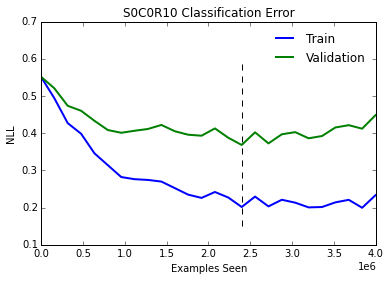

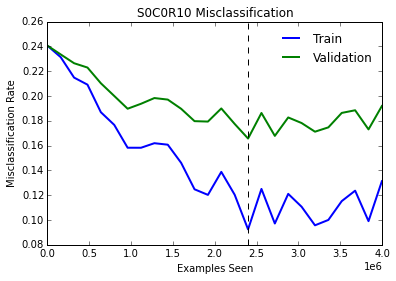

In [47]:
plot_results(diffs[0])

## S4 C0 R10

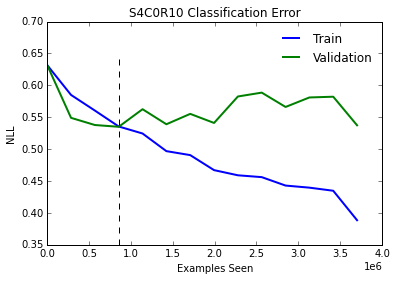

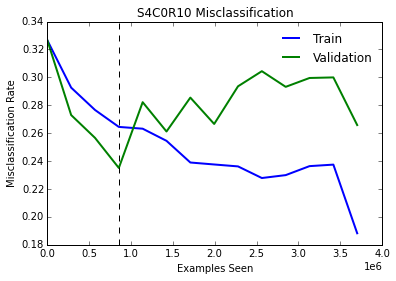

In [120]:
plot_results(diffs[1])

## S4 C4 R10

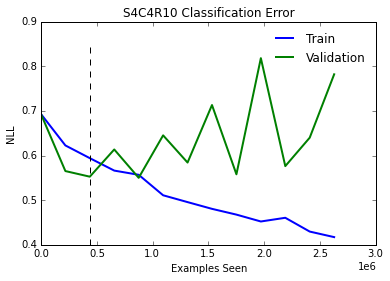

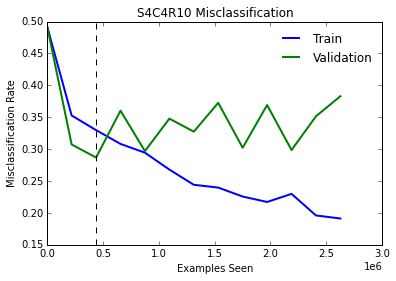

In [121]:
plot_results(diffs[2])

## S4 C4 R20

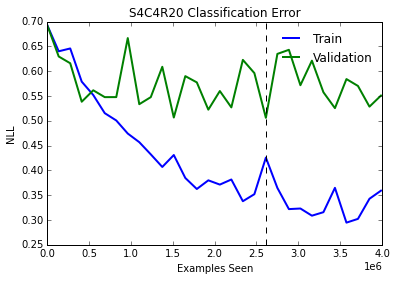

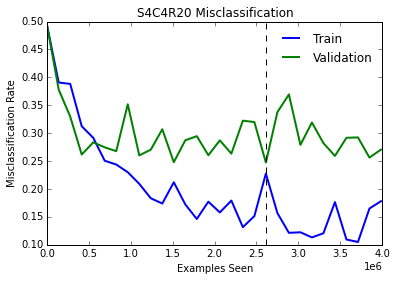

In [122]:
plot_results(diffs[3])

# Training performance

Here, we give the output for each of the different examples that are provided, and analyze the performance of the algorithm to predict the correct locations.  Unfortunately, we don't have a separate set of labeled test data to check our algorithm against.

In [128]:
def ffwd_nn(scr, X):
    save_file = os.path.join(output_dir, "nn_train_best.pkl").format(**scr._asdict())
    model = serial.load(save_file)
    
    b = []
    w = []
    for i, layer in enumerate(model.layers):
        bias = layer.b.get_value().astype(np.float32)
        try:
            # RectifiedLinear uses trainsformer
            weights = layer.transformer.get_params()[0].get_value().astype(np.float32)
        except AttributeError:
            # Softmax uses W
            weights = layer.W.get_value().astype(np.float32)
        b.append(bias)
        w.append(weights)
    
    # Run through the net
    
    # RegularizedLinear 1
    X = np.dot(X, w[0])
    X += b[0]
    X[X < 0] = 0

    # RegularizedLinear 2
    X = np.dot(X, w[1])
    X += b[1]
    X[X < 0] = 0

    # RegularizedLinear 3
    X = np.dot(X, w[2])
    X += b[2]
    X[X < 0] = 0

    # Softmax
    X = np.dot(X, w[3])
    X += b[3]
    X = X.argmax(axis=1)
    
    return X

def solve(scr):
    # Read in the data and make a value for outputs
    #height = read_raw(raw_file.format(**scr._asdict()), height_rows, height_cols)
    # Read in the image (needed for input to NN)
    image = read_pgm(pgm_file.format(**scr._asdict()))
    # Read in the solution
    soln = read_pgm(soln_file.format(**scr._asdict()))
    # Read in the preprocessed input
    preproc = read_pgm(preprocessing_pgm.format(**scr._asdict()))
    
    # Determine number that need to feed into net
    n_input = np.sum(preproc == UNKNOWN)
    # and allocate an array for it
    df_input = np.empty((n_input, nn_feat), dtype=np.float32)
    
    row, col = np.indices((soln.shape))
    # Populate each array
    sel = (preproc == UNKNOWN)
    rows, cols = row[sel].flatten(), col[sel].flatten()
    for n, (i, j) in enumerate(zip(rows, cols)):
        df_input[n, :] = image[i-nn_window//2-1:i+nn_window//2,
                               j-nn_window//2-1:j+nn_window//2].flatten()
    
    # Normalize output
    df_input = (df_input - 159) / 256
    
    # Run it through the net
    df_output = ffwd_nn(scr, df_input)
    # and put the solution in for the unknown values
    preproc[sel] = df_output * 0xff
    
    # Determine how well the net did
    perf = np.sum(df_output * 0xff == soln[sel]) / df_output.shape[0]
    print("Net Accuracy:      {:.1%}".format(perf))
    
    # write out the solved pgm
    write_pgm(preproc, final_pgm.format(**scr._asdict()))
    
    # write out the comparison png file
    cmp_file = os.path.join(output_dir, "final.png").format(**scr._asdict())
    compare_output(preproc, soln, cmp_file)

## S0 C0 R10

In [129]:
solve(diffs[0])

Net Accuracy:      90.0%
Accuracy:          98.2%
F1 (safe):         0.99
F1 (unsafe):       0.95

Safe classification accuracy:   100.0% (805592 / 805896)
Unsafe classification accuracy: 91.0% (176683 / 194104)


**Compare to winning team:**

```
Accuracy:          98.28%
F1:                0.99
```

![](../Sean/nn_files_S0C0R10/final.png)

## S4 C0 R10

In [130]:
solve(diffs[1])

Net Accuracy:      73.8%
Accuracy:          91.2%
F1 (safe):         0.83
F1 (unsafe):       0.94

Safe classification accuracy:   96.6% (210748 / 218182)
Unsafe classification accuracy: 89.7% (701380 / 781818)


**Compare to winning team:**
```
Accuracy:          96.74%
F1:                0.94
```

![](../Sean/nn_files_S4C0R10/final.png)

## S4 C4 R10

In [131]:
solve(diffs[2])

Net Accuracy:      67.4%
Accuracy:          91.6%
F1 (safe):         0.70
F1 (unsafe):       0.95

Safe classification accuracy:   77.7% (96636 / 124352)
Unsafe classification accuracy: 93.6% (819547 / 875648)


**Compare to winning team:**
```
Accuracy:          96.78%
F1:                0.8819
```

![](../Sean/nn_files_S4C4R10/final.png)

## S4 C4 R20

In [132]:
solve(diffs[3])

Net Accuracy:      77.0%
Accuracy:          95.6%
F1 (safe):         0.77
F1 (unsafe):       0.98

Safe classification accuracy:   87.1% (75313 / 86465)
Unsafe classification accuracy: 96.4% (880783 / 913535)


**Compare to winning team:**
```
Accuracy:          96.50%
F1:                0.81
```

![](../Sean/nn_files_S4C4R20/final.png)